# Udacity Self-Driving Car Engineer Nanodegree Program
## Project: Vehicle Detection and Tracking

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Load training data

In [1]:
import glob

car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

print(len(car_images), 'vehicles loaded.')
print(len(noncar_images), 'non-vehicles loaded.')

8792 vehicles loaded.
8968 non-vehicles loaded.


### Visualize some of the training data

Here is a helper method to plot two images side-by-side:

In [52]:
def plot_images_side_by_side(left_img, left_title, right_img, right_title):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    :param left_img: Image to be plotted on the left side.
    :param left_title: Title to be plotted on the left side.
    :param right_img: Image to be plotted on the right side.
    :param right_title: Title to be plotted on the right side.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    fig.tight_layout()
    axes[0].imshow(left_img, cmap='gray')
    axes[0].set_title(left_title, fontsize=14)
    axes[1].imshow(right_img, cmap='gray')
    axes[1].set_title(right_title, fontsize=14)
    return

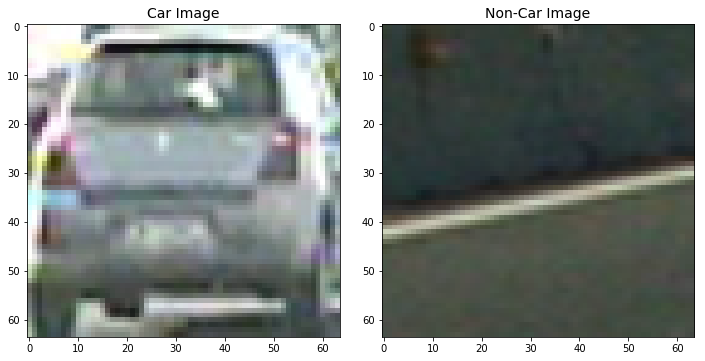

In [53]:
def plot_car_and_noncar():
    car_img = mpimg.imread(car_images[1346])
    noncar_img = mpimg.imread(noncar_images[367])
    plot_images_side_by_side(car_img, 'Car Image', noncar_img, 'Non-Car Image')

plot_car_and_noncar()

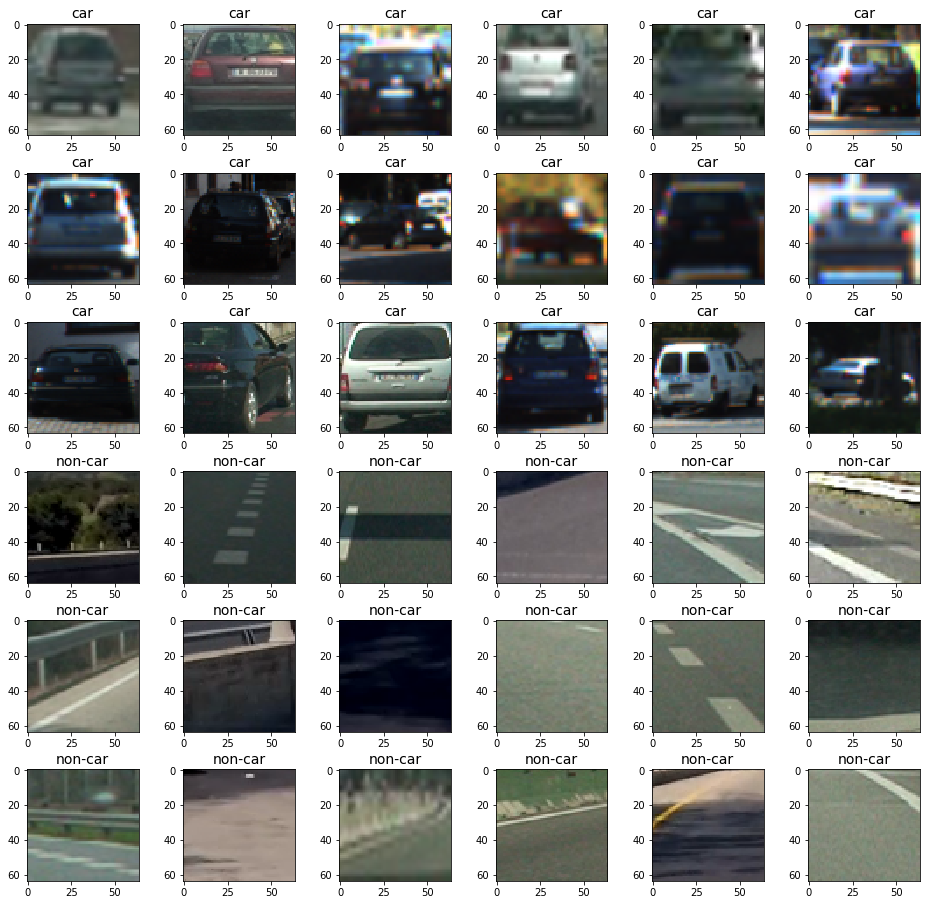

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

fig, axes = plt.subplots(6, 6, figsize=(16,16))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = axes.ravel()

i=0
# Pick some car images randomly and plot them
for filepath in np.random.choice(car_images, 18):
    img = mpimg.imread(filepath)
    axes[i].set_title('car', fontsize=14)
    axes[i].imshow(img)
    i += 1
# Pick some non-car images randomly and plot them
for filepath in np.random.choice(noncar_images, 18):
    img = mpimg.imread(filepath)
    axes[i].set_title('non-car', fontsize=14)
    axes[i].imshow(img)
    i += 1

### Define a function to return HOG features and visualization

_The code for this method was mostly copied from the Udacity lesson materials:_

In [3]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis,
                                  feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis,
                       feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

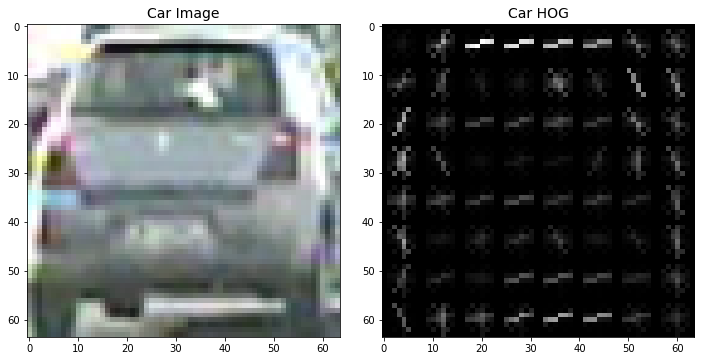

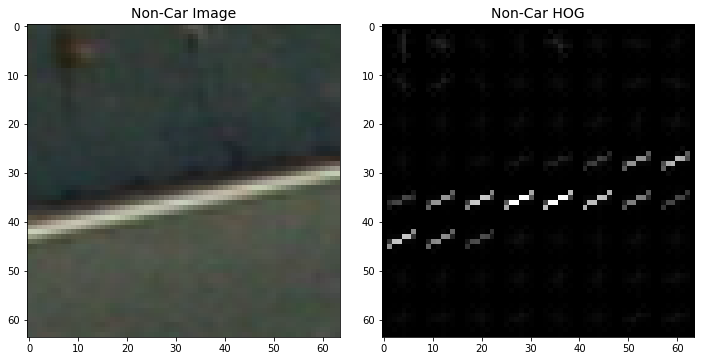

In [56]:
def test_car():
    img = mpimg.imread(car_images[1346])
    features, hog_image = get_hog_features(img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
    plot_images_side_by_side(img, 'Car Image', hog_image, 'Car HOG')

def test_non_car():
    img = mpimg.imread(noncar_images[367])
    features, hog_image = get_hog_features(img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
    plot_images_side_by_side(img, 'Non-Car Image', hog_image, 'Non-Car HOG')

test_car()
test_non_car()

### Define a function to compute binned color features

_The code for this method was copied from the Udacity lesson materials:_

In [ ]:
import cv2

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

### Define a function to compute color histogram features

_The code for this method was mostly copied from the Udacity lesson materials:_

In [ ]:
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel_1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel_2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel_3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel_1_hist[0], channel_2_hist[0], channel_3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Extract features from a single image

_The code for this method was mostly copied from the Udacity lesson materials:_

In [ ]:
def extract_single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                                orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space == 'RGB':
        feature_image = np.copy(img)
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial()
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        features.append(spatial_features)
    
    # Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        features.append(hist_features)
    
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    
    # Return concatenated array of feature vectors
    return np.concatenate(features)

### Extract features from a list of images

_The code for this method was mostly copied from the Udacity lesson materials:_

In [ ]:
def extract_multiple_img_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                                  orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                  spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)
        # Extract features from a single image
        img_features = extract_single_img_features(img,
                                                   color_space=color_space,
                                                   spatial_size=spatial_size,
                                                   hist_bins=hist_bins,
                                                   orient=orient,
                                                   pix_per_cell=pix_per_cell,
                                                   cell_per_block=cell_per_block,
                                                   hog_channel=hog_channel,
                                                   spatial_feat=spatial_feat,
                                                   hist_feat=hist_feat,
                                                   hog_feat=hog_feat)
        # Append the features from the single image to the features list
        features.append(img_features)
    # Return list of feature vectors
    return features

In [ ]:
import time

# Parameters
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (16, 16)   # Spatial binning dimensions
hist_bins      = 16         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off
y_start_stop   = [420, 720] # Min and max in y to search in slide_window()

#colorspace     = 'HLS'      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient         = 11
#pix_per_cell   = 8
#cell_per_block = 2
#spatial_size   = (16, 16)   # Spatial binning dimensions
#hist_bins      = 32         # Number of histogram bins
#hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_multiple_img_features(car_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_multiple_img_features(noncar_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()

print(round(t2-t, 2), 'seconds to extract HOG features.')
print('Using', orient, 'HOG orientations,',
      pix_per_cell, 'HOG pixels per cell, and',
      cell_per_block, 'HOG cells per block')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create an array of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)
# Fit a per-column scaler - if combining different types of features (HOG + color_hist/bin_spatial)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

### Train classifier

In [ ]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train linear SVC.')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('Linear SVC predicts:', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels:', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict', n_predict, 'labels with linear SVC.')

### Define a single function that can extract features using hog sub-sampling and make predictions

_The code for this method was mostly copied from the Udacity lesson materials:_

In [ ]:
def convert_color(img, color_space='RGB'):
    # Apply color conversion if other than 'RGB'
    if color_space == 'RGB':
        return np.copy(img)
    elif color_space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [ ]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=False):
    # Array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # Apply color conversion
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    
    # Rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 # - 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            ######################################################################
            #test_prediction = svc.predict(hog_features)
            ######################################################################
            
            if test_prediction == 1 or show_all_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return rectangles

### Define a function to draw bounding boxes

_The code for this method was mostly copied from the Udacity lesson materials:_

In [ ]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
rectangles = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

out_img = draw_boxes(img, rectangles)

print('Number of boxes: ', len(rectangles))
plt.figure(figsize=(10,10))
plt.imshow(out_img)


### Sliding window technique

### Show all potential search areas

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

rectangles = [item for sublist in rects for item in sublist] 
out_img = draw_boxes(img, rectangles, color='random', thick=2)

print('Number of boxes: ', len(rectangles))
plt.figure(figsize=(16,16))
plt.imshow(out_img)

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

rectangles = [item for sublist in rects for item in sublist] 
out_img = draw_boxes(img, rectangles, color='random', thick=2)

print('Number of boxes: ', len(rectangles))
plt.figure(figsize=(16,16))
plt.imshow(out_img)

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

rectangles = [item for sublist in rects for item in sublist] 
out_img = draw_boxes(img, rectangles, color='random', thick=2)

print('Number of boxes: ', len(rectangles))
plt.figure(figsize=(16,16))
plt.imshow(out_img)

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_windows=True))

rectangles = [item for sublist in rects for item in sublist] 
out_img = draw_boxes(img, rectangles, color='random', thick=2)

print('Number of boxes: ', len(rectangles))
plt.figure(figsize=(16,16))
plt.imshow(out_img)

### Combine previous search windows

In [ ]:
def find_cars_on_street(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    rects = []
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 432
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 528
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 596
    scale = 3.0
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 464
    ystop = 660
    scale = 3.0
    rects.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    rectangles = [item for sublist in rects for item in sublist]
    return rectangles

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')

rectangles = find_cars_on_street(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(img, rectangles, color='random', thick=2)

print('Number of boxes: ', len(rectangles))
plt.figure(figsize=(16,16))
plt.imshow(out_img)

### Heatmap

_The code for this method was copied from the Udacity lesson materials:_

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

In [ ]:
# Test the heatmap
img = mpimg.imread('./test_images/test1.jpg')
heatmap = np.zeros_like(img[:,:,0])
heatmap = add_heat(heatmap, rectangles)
plt.figure(figsize=(16,16))
plt.imshow(heatmap, cmap='hot')

### Heatmap threshold

_The code for this method was copied from the Udacity lesson materials:_

In [ ]:
def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [ ]:
# Test the heatmap threshold
heatmap = apply_threshold(heatmap, 1)
plt.figure(figsize=(16,16))
plt.imshow(heatmap, cmap='hot')

### Add SciPy labels to heatmap

Once we have a thresholded heat-map, there are many ways we could go about trying to figure out how many cars we have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the `label()` function from `scipy.ndimage.measurements`.

In [ ]:
from scipy.ndimage.measurements import label

labels = label(heatmap)

print(labels[1], 'cars found')
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gray')

### Draw bounding boxes for labeled regions

_The code for this method was copied from the Udacity lesson materials:_

In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)

# Display the image
plt.figure(figsize=(16,16))
plt.imshow(draw_img)

### Finally, put it all together to a pipeline (without history)

In [ ]:
def process_frame(img):
    # Find cars on the street
    rectangles = find_cars_on_street(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Create heatmap
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    # Add threshold to heatmap
    heatmap_img = apply_threshold(heatmap_img, 1)
    # Add SciPy labels to heatmap
    labels = label(heatmap_img)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    # Return image with bounding boxes drawn on it
    return draw_img

Run the pipeline on all test images

In [ ]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Create a history class and rebuild pipeline (with history)

In [ ]:
class Detector:
    def __init__(self):
        self.previous_rects = []
    
    def add_rects(self, rects):
        # Add new rectangles
        self.previous_rects.append(rects)
        # Clean up
        if len(self.previous_rects) > 8:
            # Remove oldest item
            self.previous_rects = self.previous_rects[1:]

In [ ]:
def process_frame(img):
    # Find cars on the street
    rectangles = find_cars_on_street(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add rectangles to history
    if len(rectangles) > 0:
        detector.add_rects(rectangles)
    
    # Create heatmap
    heatmap_img = np.zeros_like(img[:,:,0])
    for rects in detector.previous_rects:
        heatmap_img = add_heat(heatmap_img, rects)
    
    # Add threshold to heatmap
    heatmap_img = apply_threshold(heatmap_img, 1 + len(detector.previous_rects) // 2)
    
    # Add SciPy labels to heatmap
    labels = label(heatmap_img)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    # Return image with bounding boxes drawn on it
    return draw_img

### Video processing: Test Video

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
detector = Detector()

white_output = './output_videos/test_video_output.mp4'

# Load video clip
clip = VideoFileClip('./test_video.mp4')

# Process video clip
white_clip = clip.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Video processing: Project Video

In [ ]:
detector = Detector()

white_output = './output_videos/project_video_output.mp4'

# Load video clip
clip = VideoFileClip('./project_video.mp4')

# Process video clip
white_clip = clip.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))